# **KAN: Kolmogorov-Arnold Networks**
*By Cristian Leo*

[Link to Article](https://medium.com/towards-data-science/the-math-behind-kan-kolmogorov-arnold-networks-7c12a164ba95)

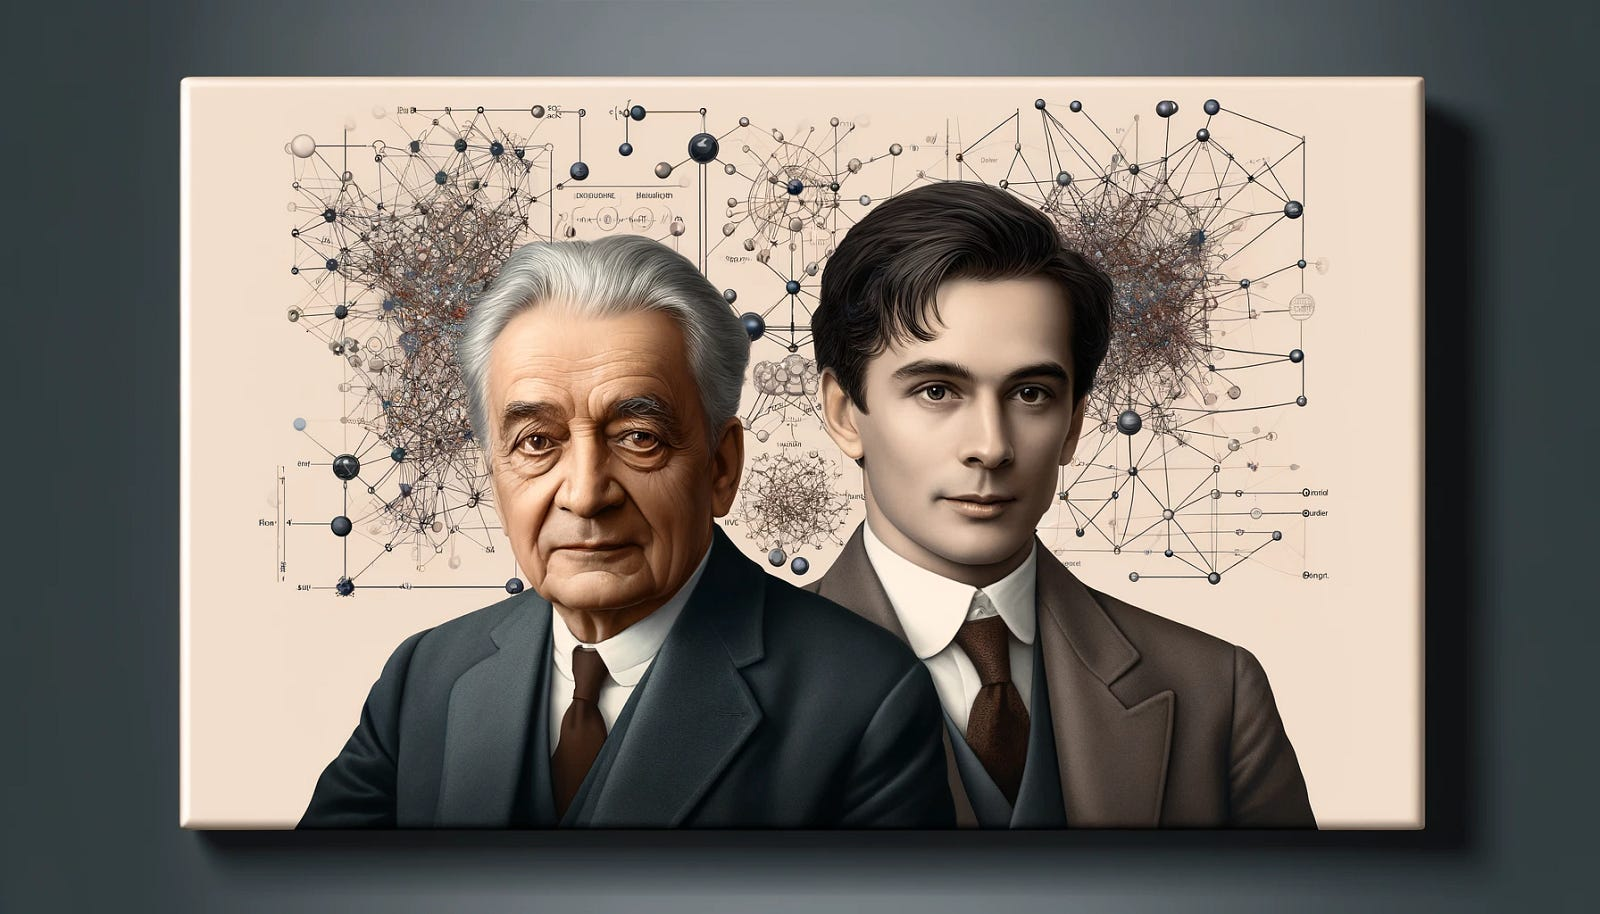

In [1]:
import numpy as np # linear algebra

import torch # PyTorch
import torch.nn as nn # Neural network module
from torchsummary import summary # Model summary
from kan import KAN, create_dataset # KAN model and dataset

import matplotlib.pyplot as plt # Plotting

import warnings
warnings.filterwarnings("ignore")

/Users/cristianleo/Documents/Documents - Cristian’s Laptop/GitHub/models-from-scratch-python/venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

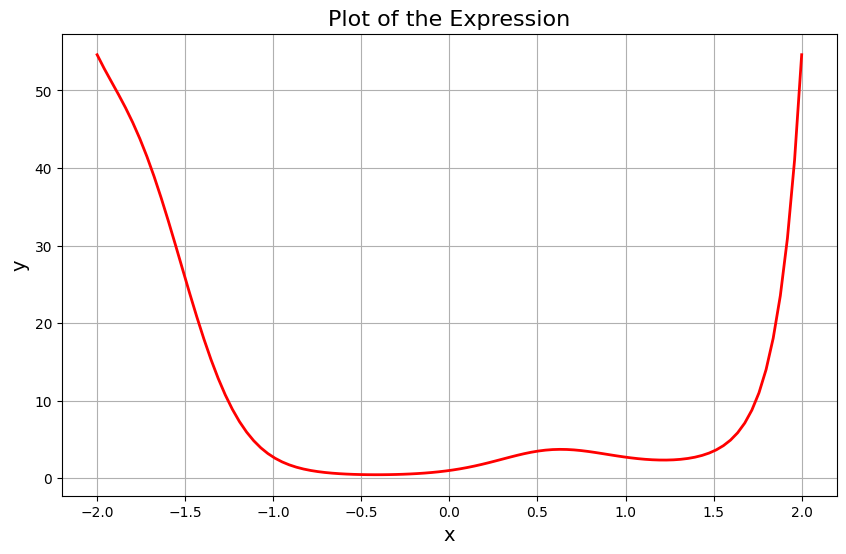

In [3]:
# Create a tensor of points
x = torch.linspace(-2, 2, 100)

# Compute the expression
y = torch.exp(torch.sin(torch.pi*x) + x**2)

# Convert the result back to a numpy array
y = y.detach().numpy()

# Create the plot
plt.figure(figsize=(10, 6))  # Increase the size of the figure
plt.plot(x, y, 'r-', linewidth=2)  # Change the line color to red and increase the line width

# Add title and labels
plt.title('Plot of the Expression', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

# Add a grid
plt.grid(True)

# Show the plot
plt.show()

In [4]:
grids = np.array([5,10,20,50,100])

train_losses_kan = []
test_losses_kan = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses_kan += results['train_loss']
    test_losses_kan += results['test_loss']

print(f"Train RMSE: {results['train_loss'][-1]:.8f} | Test RMSE: {results['test_loss'][-1]:.8f}")

train loss: 6.41e-03 | test loss: 6.56e-03 | reg: 2.78e+00 : 100%|██| 50/50 [00:05<00:00,  8.37it/s]
train loss: 2.87e-04 | test loss: 3.27e-04 | reg: 2.79e+00 : 100%|██| 50/50 [00:05<00:00,  9.92it/s]
train loss: 2.03e-05 | test loss: 2.38e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:04<00:00, 10.60it/s]
train loss: 4.74e-06 | test loss: 1.42e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:05<00:00,  9.87it/s]
train loss: 2.60e-06 | test loss: 1.37e-05 | reg: 2.79e+00 : 100%|██| 50/50 [00:04<00:00, 10.53it/s]

Train RMSE: 0.00000260 | Test RMSE: 0.00001374


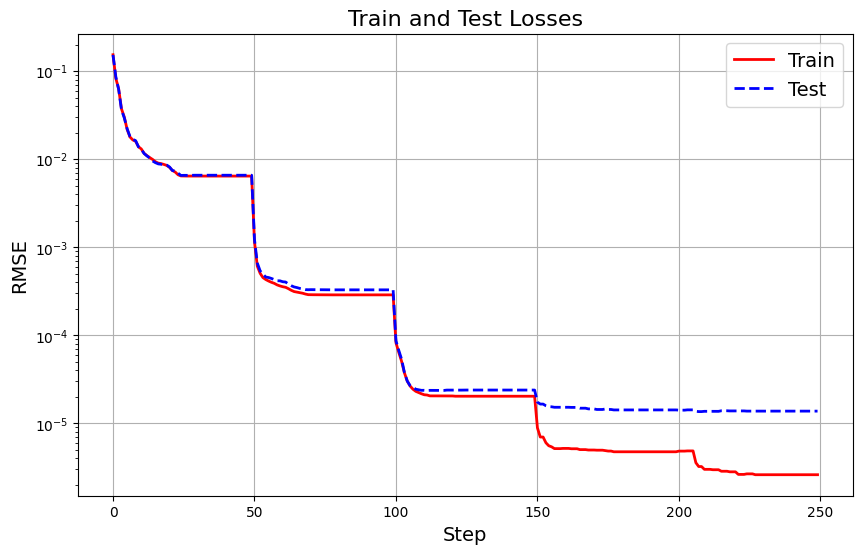

In [5]:
plt.figure(figsize=(10, 6))  # Increase the size of the figure
plt.plot(train_losses_kan, 'r-', linewidth=2)  # Change the line color to red and increase the line width
plt.plot(test_losses_kan, 'b--', linewidth=2)  # Change the line color to blue, use dashed line style and increase the line width
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Train and Test Losses', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.yscale('log')
plt.grid(True)  # Add a grid
plt.show()

In [6]:
# Define the MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dataset['train_input'].shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = MLP()

summary(model, input_size=(dataset['train_input'].shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             192
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 1]              65
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [7]:
# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

train_loss_mlp = []
test_loss_mlp = []

# Train the model
epochs = 250
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(dataset['train_input']).squeeze()
    loss = criterion(output, dataset['train_label'])
    loss.backward()
    optimizer.step()
    train_loss_mlp.append(loss.item()**0.5)

    # Test the model
    model.eval()
    with torch.no_grad():
        output = model(dataset['test_input']).squeeze()
        loss = criterion(output, dataset['test_label'])
        test_loss_mlp.append(loss.item()**0.5)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_mlp[-1]:.2f}, Test Loss: {test_loss_mlp[-1]:.2f}', end='\r')

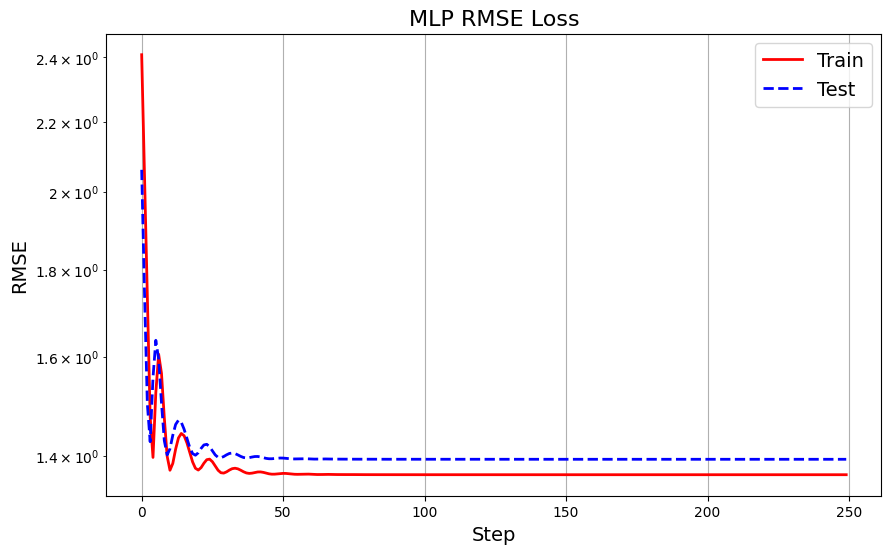

In [8]:
plt.figure(figsize=(10, 6))  # Increase the size of the figure
plt.plot(train_loss_mlp, 'r-', linewidth=2)  # Change the line color to red and increase the line width
plt.plot(test_loss_mlp, 'b--', linewidth=2)  # Change the line color to blue, use dashed line style and increase the line width
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('MLP RMSE Loss', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.yscale('log')
plt.grid(True)  # Add a grid
plt.show()

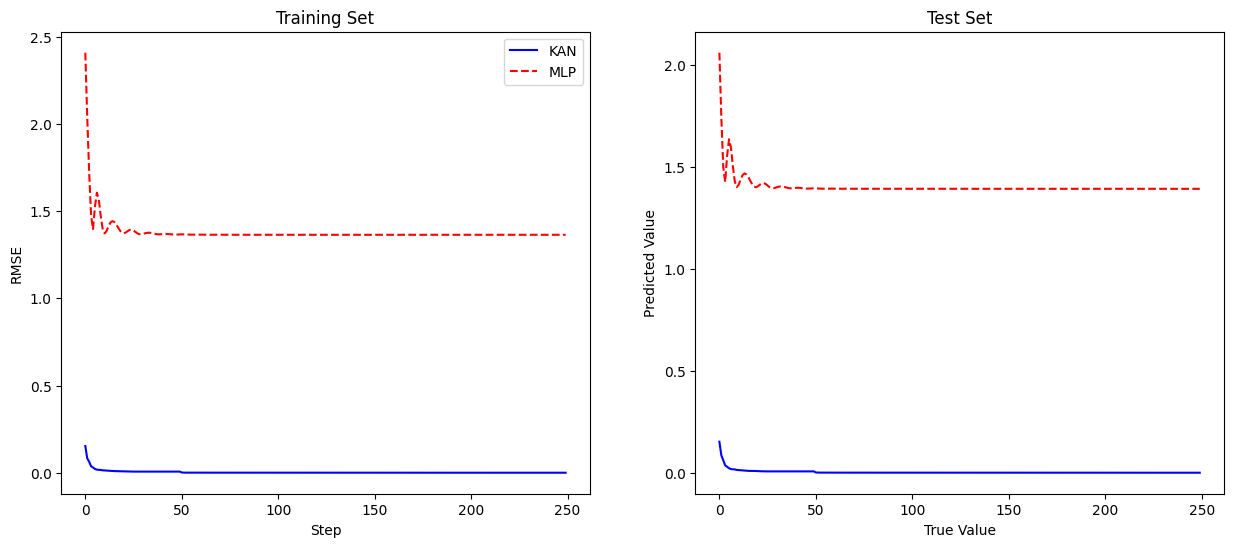

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the KAN model vs the MLP model on the training set
ax[0].plot(train_losses_kan, 'b-')
ax[0].plot(train_loss_mlp, 'r--')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('RMSE')
ax[0].legend(['KAN', 'MLP'])

# Plot the KAN model vs the MLP model on the test set
ax[1].plot(test_losses_kan, 'b-')
ax[1].plot(test_loss_mlp, 'r--')
ax[1].set_title('Test Set')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')

plt.show()